In [1]:
!pip install newspaper3k
!pip install autoscraper
#!pip install feedparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13538 sha256=f18f42acae8b67e331d9e5aeab19140c834c8248ac38b493d3e4ac0b974c94cc
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3340 sha256=738c5172ebb7ff1fce418d610115ec2e3385ed08e8e485833f4ffb5669d1988e
  Stored in directory: /root/.cache/pip/wheels/97/02/e7/a1ff1760e12bdbaab0ac824fae5c1bc

In [2]:
import pandas as pd
from autoscraper import AutoScraper
from bs4 import BeautifulSoup
import requests

In [3]:
url_to_scrape="https://www.thestar.com.my/news/latest?tag=Nation"

response = requests.get(url_to_scrape)

soup = BeautifulSoup(response.text, 'html.parser')

# Find all <h2> tags with class "f18"
h2_tags = soup.find_all('h2', class_='f18')

for h2_tag in h2_tags:
    # Find the <a> tag within the <h2> tag
    a_tag = h2_tag.find('a')
    if a_tag:
        # Extract the link
        link = a_tag['href']

        break

In [4]:
link

'https://www.thestar.com.my/news/nation/2024/05/11/kkb-polls-pakatan-ahead-as-early-voting-ballots-counted-unofficial'

In [5]:
WantedLink=[link]

Scraper = AutoScraper()
url = Scraper.build(url_to_scrape, wanted_list=WantedLink)

In [6]:
%%time

base_url = "https://www.thestar.com.my/news/latest?pgno={}&tag={}"
tags = ["Business", "Politics", "Arts", "Sport", "Celebrities"]


all_news_urls = []

# Loop through each tag and page number
for tag in tags:
    for page_num in range(1, 11):  # Loop through 10 pages
        url_to_scrape = base_url.format(page_num, tag)

        # Get similar result for the current tag and page
        similar_results = Scraper.get_result_similar(url_to_scrape)

        all_news_urls.extend(similar_results)

CPU times: user 8.27 s, sys: 152 ms, total: 8.42 s
Wall time: 1min 15s


In [7]:
all_news_urls[:10]

['https://www.thestar.com.my/business/2024/05/11/wall-st-week-ahead-earnings-bolster-us-stocks',
 'https://www.thestar.com.my/business/2024/05/11/wall-st-posts-another-weekly-gain-ahead-of-inflation-data',
 'https://www.thestar.com.my/business/business-news/2024/05/11/new-capacity-in-the-pipeline',
 'https://www.thestar.com.my/business/business-news/2024/05/11/phison-makes-another-attempt-to-enter-malaysias-tech-space',
 'https://www.thestar.com.my/business/business-news/2024/05/11/coordinated-approach-crucial-to-strengthen-smes',
 'https://www.thestar.com.my/business/business-news/2024/05/11/wellness-a-top-priority',
 'https://www.thestar.com.my/business/business-news/2024/05/11/focusing-on-affordability',
 'https://www.thestar.com.my/business/business-news/2024/05/11/hong-kong-housing-urban-renewal-groups-in-rare-loan-talks',
 'https://www.thestar.com.my/business/insight/2024/05/11/us-is-a-monopoly',
 'https://www.thestar.com.my/business/business-news/2024/05/11/chinas-push-for-green

In [8]:
len(all_news_urls)
#paper.__dict__

926

In [9]:
%%time

import newspaper
from newspaper import Config

config = Config()
config.request_timeout = 30

article_details_list = []
# Loop through each URL
for url in all_news_urls:
    try:
        article = newspaper.Article(url=url, language='en', config=config)
        article.download()
        article.parse()

        meta_data = article.meta_data
        content_id = meta_data.get('content_id', None)
        section_name = meta_data.get('article_section_name', None)
        category = meta_data['cXenseParse'].get('kicker_name', None)
        tags = meta_data.get('content_tags', None)
        summary = meta_data.get('description', None)
        content_agency = meta_data.get('content_agency', None)
        content_tier =  meta_data.get('content_tier', None)
        content_length = meta_data.get('content_length', None)
        authors = meta_data.get('author', None)
        article_detail ={
            "content_id" : content_id,
            "title": str(article.title),
            "text": str(article.text),
            "section" : section_name,
            "category" :category,
            "content_tier":content_tier,
            "content_length":content_length,
            "authors": authors,
            "published_date": str(article.publish_date),
            #"videos": article.movies,
            "keywords": tags,
            "summary": summary,
            "url": url,
            "top_image": str(article.top_image),
        }

        article_details_list.append(article_detail)

    except newspaper.ArticleException as e:
        print(f"Failed to process URL: {url}. Error: {e}")

df_star = pd.DataFrame(article_details_list)

Failed to process URL: https://www.thestar.com.my/business/business-news/2024/05/10/ringgit-ends-firmer-against-us-dollar. Error: Article `download()` failed with 502 Server Error: Bad Gateway for url: https://www.thestar.com.my/business/business-news/2024/05/10/ringgit-ends-firmer-against-us-dollar on URL https://www.thestar.com.my/business/business-news/2024/05/10/ringgit-ends-firmer-against-us-dollar
Failed to process URL: https://www.thestar.com.my/business/business-news/2024/05/11/phison-makes-another-attempt-to-enter-malaysias-tech-space. Error: Article `download()` failed with HTTPSConnectionPool(host='www.thestar.com.my', port=443): Read timed out. (read timeout=30) on URL https://www.thestar.com.my/business/business-news/2024/05/11/phison-makes-another-attempt-to-enter-malaysias-tech-space
Failed to process URL: https://www.thestar.com.my/sport/football/2024/05/08/. Error: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thestar.com.my/sport/fo

In [10]:
df_star.head()

,content_id,title,text,section,category,content_tier,content_length,authors,published_date,keywords,summary,url,top_image
0,1345935,Wall St Week Ahead: Earnings bolster US stocks,NEW YORK: A strong earnings season and blockbu...,Business,Markets,Metered,Short,None,2024-05-11 00:00:00,"Markets,USStockMarketRebound,TechEarningsPower...",A strong earnings season and blockbuster repor...,https://www.thestar.com.my/business/2024/05/11...,https://apicms.thestar.com.my/uploads/images/2...
1,1345932,Wall St posts another weekly gain ahead of inf...,NEW YORK: US stocks eked out modest gains on F...,Business,Markets,Metered,Short,None,2024-05-11 00:00:00,"Markets,ModestUSGains,FedCommentary,PreInflati...",US stocks eked out modest gains on Friday and ...,https://www.thestar.com.my/business/2024/05/11...,https://apicms.thestar.com.my/uploads/images/2...
2,1345781,New capacity in the pipeline,THE data centre industry globally is seeing a ...,Business,Economy,Metered,Short,None,2024-05-11 00:00:00,"Economy,MalaysiaDataCentreBoom,CloudAI,TechInv...",The data centre industry globally is seeing a ...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
3,1345767,Phison makes another attempt to enter Malaysia...,IN a move marking its return to Malaysia’s tec...,Business,Corporate News,Metered,Short,None,2024-05-11 00:00:00,"Corporate News,PhisonMalaysia,TechInvestment,M...",In a move marking its return to Malaysia’s tec...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
4,1345768,Coordinated approach crucial to strengthen SMEs,THAT small and medium enterprises (SMEs) are a...,Business,Corporate News,Metered,Short,None,2024-05-11 00:00:00,"Corporate News,SMEResilience,GovernmentSupport...",That small and medium enterprises (SMEs) are a...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...


In [14]:
# prompt: save df_star as news1_v1.csv

df_star.to_csv('/content/drive/MyDrive/Classroom/news1_v1.csv', index=False)


In [36]:
prev_df = pd.read_csv("/content/drive/MyDrive/Classroom/news1_v1.csv")
prev_df.head()

,content_id,title,text,section,category,content_tier,content_length,authors,published_date,keywords,summary,url,top_image
0,1345935,Wall St Week Ahead: Earnings bolster US stocks,NEW YORK: A strong earnings season and blockbu...,Business,Markets,Metered,Short,NaN,2024-05-11 00:00:00,"Markets,USStockMarketRebound,TechEarningsPower...",A strong earnings season and blockbuster repor...,https://www.thestar.com.my/business/2024/05/11...,https://apicms.thestar.com.my/uploads/images/2...
1,1345932,Wall St posts another weekly gain ahead of inf...,NEW YORK: US stocks eked out modest gains on F...,Business,Markets,Metered,Short,NaN,2024-05-11 00:00:00,"Markets,ModestUSGains,FedCommentary,PreInflati...",US stocks eked out modest gains on Friday and ...,https://www.thestar.com.my/business/2024/05/11...,https://apicms.thestar.com.my/uploads/images/2...
2,1345781,New capacity in the pipeline,THE data centre industry globally is seeing a ...,Business,Economy,Metered,Short,NaN,2024-05-11 00:00:00,"Economy,MalaysiaDataCentreBoom,CloudAI,TechInv...",The data centre industry globally is seeing a ...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
3,1345767,Phison makes another attempt to enter Malaysia...,IN a move marking its return to Malaysia’s tec...,Business,Corporate News,Metered,Short,NaN,2024-05-11 00:00:00,"Corporate News,PhisonMalaysia,TechInvestment,M...",In a move marking its return to Malaysia’s tec...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
4,1345768,Coordinated approach crucial to strengthen SMEs,THAT small and medium enterprises (SMEs) are a...,Business,Corporate News,Metered,Short,NaN,2024-05-11 00:00:00,"Corporate News,SMEResilience,GovernmentSupport...",That small and medium enterprises (SMEs) are a...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...


In [37]:
df_updated = pd.concat([df_star, prev_df], ignore_index=True)
df_updated.head()

,content_id,title,text,section,category,content_tier,content_length,authors,published_date,keywords,summary,url,top_image
0,1345935,Wall St Week Ahead: Earnings bolster US stocks,NEW YORK: A strong earnings season and blockbu...,Business,Markets,Metered,Short,None,2024-05-11 00:00:00,"Markets,USStockMarketRebound,TechEarningsPower...",A strong earnings season and blockbuster repor...,https://www.thestar.com.my/business/2024/05/11...,https://apicms.thestar.com.my/uploads/images/2...
1,1345932,Wall St posts another weekly gain ahead of inf...,NEW YORK: US stocks eked out modest gains on F...,Business,Markets,Metered,Short,None,2024-05-11 00:00:00,"Markets,ModestUSGains,FedCommentary,PreInflati...",US stocks eked out modest gains on Friday and ...,https://www.thestar.com.my/business/2024/05/11...,https://apicms.thestar.com.my/uploads/images/2...
2,1345781,New capacity in the pipeline,THE data centre industry globally is seeing a ...,Business,Economy,Metered,Short,None,2024-05-11 00:00:00,"Economy,MalaysiaDataCentreBoom,CloudAI,TechInv...",The data centre industry globally is seeing a ...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
3,1345767,Phison makes another attempt to enter Malaysia...,IN a move marking its return to Malaysia’s tec...,Business,Corporate News,Metered,Short,None,2024-05-11 00:00:00,"Corporate News,PhisonMalaysia,TechInvestment,M...",In a move marking its return to Malaysia’s tec...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
4,1345768,Coordinated approach crucial to strengthen SMEs,THAT small and medium enterprises (SMEs) are a...,Business,Corporate News,Metered,Short,None,2024-05-11 00:00:00,"Corporate News,SMEResilience,GovernmentSupport...",That small and medium enterprises (SMEs) are a...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...


In [38]:
df_updated = df_updated.drop_duplicates(subset='content_id', keep='last')
df_updated

,content_id,title,text,section,category,content_tier,content_length,authors,published_date,keywords,summary,url,top_image
924,1345781,New capacity in the pipeline,THE data centre industry globally is seeing a ...,Business,Economy,Metered,Short,NaN,2024-05-11 00:00:00,"Economy,MalaysiaDataCentreBoom,CloudAI,TechInv...",The data centre industry globally is seeing a ...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
934,1345779,SIA reaching new heights,"I am not a betting man, but if I were, I’d pla...",Business,Insight,Metered,Short,NaN,2024-05-11 00:00:00,"Commentary,SIA,RecordProfits,PassengerDemand,P...","I am not a betting man, but if I were, I’d pla...",https://www.thestar.com.my/business/insight/20...,https://apicms.thestar.com.my/uploads/images/2...
935,1345780,US-South-East Asia deal flows could be the new...,THE International Monetary Fund reported that ...,Business,Insight,Metered,Short,NaN,2024-05-11 00:00:00,"Commentary,GlobalEconomy,GrowthSlowdown,Protec...",The International Monetary Fund reported that ...,https://www.thestar.com.my/business/insight/20...,https://apicms.thestar.com.my/uploads/images/2...
937,1345786,MI Technovation posts three-fold surge in net ...,"Disclaimer: by clicking the Submit button, it ...",Business,Corporate News,Metered,Short,NaN,2024-05-11 00:00:00,"Corporate News,Mitech,semiconductorgrowth,dive...",MI Technovation Bhd (MI Tech) will continue to...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
938,1345783,"March industrial production index up 2.4%, but...","Disclaimer: by clicking the Submit button, it ...",Business,Economy,Metered,Short,NaN,2024-05-11 00:00:00,"Economy,MalaysiaIPI,SlowerGrowth,Manufacturing...",The industrial production index (IPI) rose 2.4...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,1345788,Awanbiru share suspension waiver,PETALING JAYA: Awanbiru Technology Bhd said Bu...,Business,Corporate News,Metered,Short,NaN,2024-05-11 00:00:00,"Corporate News,AwanbiruTech,BursaMalaysia,regu...",Awanbiru Technology Bhd said Bursa Malaysia ha...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
1840,1345776,Tolerance for a cheaper yuan may be temporary,CURRENCY markets are reading subtle signals fr...,Business,Economy,Metered,Short,NaN,2024-05-11 00:00:00,"Economy,ChinaYuan,ManagedWeakening,TradeCompet...",Currency markets are reading subtle signals fr...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
1841,1345777,Inari switches gear to remain relevant,IT has been a case of mixed fortunes for semic...,Business,Corporate News,Metered,Short,NaN,2024-05-11 00:00:00,"Corporate News,MsianChipDemand,SupplyChainShif...",It has been a case of mixed fortunes for semic...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
1842,1345775,China’s push for greener aluminium hit by erra...,ERRATIC rainfall in China’s southwest is frust...,Business,Economy,Metered,Short,NaN,2024-05-11 00:00:00,"Economy,ChinaAluminium,GreenMetalPush,Hydropow...",Erratic rainfall in China’s southwest is frust...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...


In [39]:
df_updated.to_csv("news_v1.csv", index=None)

In [40]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 924 to 1843
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content_id      524 non-null    int64 
 1   title           524 non-null    object
 2   text            524 non-null    object
 3   section         524 non-null    object
 4   category        523 non-null    object
 5   content_tier    524 non-null    object
 6   content_length  524 non-null    object
 7   authors         26 non-null     object
 8   published_date  524 non-null    object
 9   keywords        399 non-null    object
 10  summary         522 non-null    object
 11  url             524 non-null    object
 12  top_image       524 non-null    object
dtypes: int64(1), object(12)
memory usage: 73.5+ KB


In [41]:
# prompt: drop column authors

df_updated.drop(columns=["authors"], inplace=True)
df_updated


,content_id,title,text,section,category,content_tier,content_length,published_date,keywords,summary,url,top_image
924,1345781,New capacity in the pipeline,THE data centre industry globally is seeing a ...,Business,Economy,Metered,Short,2024-05-11 00:00:00,"Economy,MalaysiaDataCentreBoom,CloudAI,TechInv...",The data centre industry globally is seeing a ...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
934,1345779,SIA reaching new heights,"I am not a betting man, but if I were, I’d pla...",Business,Insight,Metered,Short,2024-05-11 00:00:00,"Commentary,SIA,RecordProfits,PassengerDemand,P...","I am not a betting man, but if I were, I’d pla...",https://www.thestar.com.my/business/insight/20...,https://apicms.thestar.com.my/uploads/images/2...
935,1345780,US-South-East Asia deal flows could be the new...,THE International Monetary Fund reported that ...,Business,Insight,Metered,Short,2024-05-11 00:00:00,"Commentary,GlobalEconomy,GrowthSlowdown,Protec...",The International Monetary Fund reported that ...,https://www.thestar.com.my/business/insight/20...,https://apicms.thestar.com.my/uploads/images/2...
937,1345786,MI Technovation posts three-fold surge in net ...,"Disclaimer: by clicking the Submit button, it ...",Business,Corporate News,Metered,Short,2024-05-11 00:00:00,"Corporate News,Mitech,semiconductorgrowth,dive...",MI Technovation Bhd (MI Tech) will continue to...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
938,1345783,"March industrial production index up 2.4%, but...","Disclaimer: by clicking the Submit button, it ...",Business,Economy,Metered,Short,2024-05-11 00:00:00,"Economy,MalaysiaIPI,SlowerGrowth,Manufacturing...",The industrial production index (IPI) rose 2.4...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
...,...,...,...,...,...,...,...,...,...,...,...,...
1839,1345788,Awanbiru share suspension waiver,PETALING JAYA: Awanbiru Technology Bhd said Bu...,Business,Corporate News,Metered,Short,2024-05-11 00:00:00,"Corporate News,AwanbiruTech,BursaMalaysia,regu...",Awanbiru Technology Bhd said Bursa Malaysia ha...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
1840,1345776,Tolerance for a cheaper yuan may be temporary,CURRENCY markets are reading subtle signals fr...,Business,Economy,Metered,Short,2024-05-11 00:00:00,"Economy,ChinaYuan,ManagedWeakening,TradeCompet...",Currency markets are reading subtle signals fr...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
1841,1345777,Inari switches gear to remain relevant,IT has been a case of mixed fortunes for semic...,Business,Corporate News,Metered,Short,2024-05-11 00:00:00,"Corporate News,MsianChipDemand,SupplyChainShif...",It has been a case of mixed fortunes for semic...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...
1842,1345775,China’s push for greener aluminium hit by erra...,ERRATIC rainfall in China’s southwest is frust...,Business,Economy,Metered,Short,2024-05-11 00:00:00,"Economy,ChinaAluminium,GreenMetalPush,Hydropow...",Erratic rainfall in China’s southwest is frust...,https://www.thestar.com.my/business/business-n...,https://apicms.thestar.com.my/uploads/images/2...


In [42]:
# prompt: fill keywords with most common value

df_updated['keywords'] = df_updated['keywords'].fillna(df_updated['keywords'].mode()[0])
df_updated.info()


<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 924 to 1843
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content_id      524 non-null    int64 
 1   title           524 non-null    object
 2   text            524 non-null    object
 3   section         524 non-null    object
 4   category        523 non-null    object
 5   content_tier    524 non-null    object
 6   content_length  524 non-null    object
 7   published_date  524 non-null    object
 8   keywords        524 non-null    object
 9   summary         522 non-null    object
 10  url             524 non-null    object
 11  top_image       524 non-null    object
dtypes: int64(1), object(11)
memory usage: 69.4+ KB


In [43]:
df_updated['category'] = df_updated['category'].fillna(df_updated['category'].mode()[0])

In [44]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 924 to 1843
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content_id      524 non-null    int64 
 1   title           524 non-null    object
 2   text            524 non-null    object
 3   section         524 non-null    object
 4   category        524 non-null    object
 5   content_tier    524 non-null    object
 6   content_length  524 non-null    object
 7   published_date  524 non-null    object
 8   keywords        524 non-null    object
 9   summary         522 non-null    object
 10  url             524 non-null    object
 11  top_image       524 non-null    object
dtypes: int64(1), object(11)
memory usage: 69.4+ KB


In [48]:
# prompt: Use a clustering algorithm to create clusters best on the categories of the stories

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer on the category column
X = vectorizer.fit_transform(df_updated['section'])

# Create a KMeans object with 5 clusters
kmeans = KMeans(n_clusters=5)

# Fit the KMeans object on the category column
kmeans.fit(X)

# Add the cluster labels to the DataFrame
df_updated['cluster'] = kmeans.labels_

# Print the DataFrame
print(df_updated)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


      content_id                                              title  \
924      1345781                       New capacity in the pipeline   
934      1345779                           SIA reaching new heights   
935      1345780  US-South-East Asia deal flows could be the new...   
937      1345786  MI Technovation posts three-fold surge in net ...   
938      1345783  March industrial production index up 2.4%, but...   
...          ...                                                ...   
1839     1345788                   Awanbiru share suspension waiver   
1840     1345776      Tolerance for a cheaper yuan may be temporary   
1841     1345777             Inari switches gear to remain relevant   
1842     1345775  China’s push for greener aluminium hit by erra...   
1843     1345767  Phison makes another attempt to enter Malaysia...   

                                                   text   section  \
924   THE data centre industry globally is seeing a ...  Business   
934   I a

In [49]:
# prompt: show the 5 clusters

# Print the unique cluster labels
print(df_updated['cluster'].unique())


[1 0 2 3 4]


In [52]:
for cluster_label in df_updated['cluster'].unique():
    cluster_data = df_updated[df_updated['cluster'] == cluster_label]
    print(f"Cluster {cluster_label}:")
    print(f"- Number of articles: {len(cluster_data)}")
    print(f"- Top categories: {cluster_data['section'].value_counts().head(3)}")
    print(f"- Top keywords: {cluster_data['keywords'].str.split(',').explode().value_counts().head(3)}")
    print()


Cluster 1:
- Number of articles: 196
- Top categories: section
Business    196
Name: count, dtype: int64
- Top keywords: keywords
Corporate News    92
Economy           30
Markets           21
Name: count, dtype: int64

Cluster 0:
- Number of articles: 65
- Top categories: section
AseanPlus    42
Metro        10
Tech          7
Name: count, dtype: int64
- Top keywords: keywords
SCMP        19
Cambodia     4
Thailand     4
Name: count, dtype: int64

Cluster 2:
- Number of articles: 164
- Top categories: section
Sport    164
Name: count, dtype: int64
- Top keywords: keywords
SCMP        108
Football     15
Hockey       13
Name: count, dtype: int64

Cluster 3:
- Number of articles: 90
- Top categories: section
News    90
Name: count, dtype: int64
- Top keywords: keywords
KKB Polls    12
SCMP         11
             10
Name: count, dtype: int64

Cluster 4:
- Number of articles: 9
- Top categories: section
Lifestyle    9
Name: count, dtype: int64
- Top keywords: keywords
Europe     3
touris

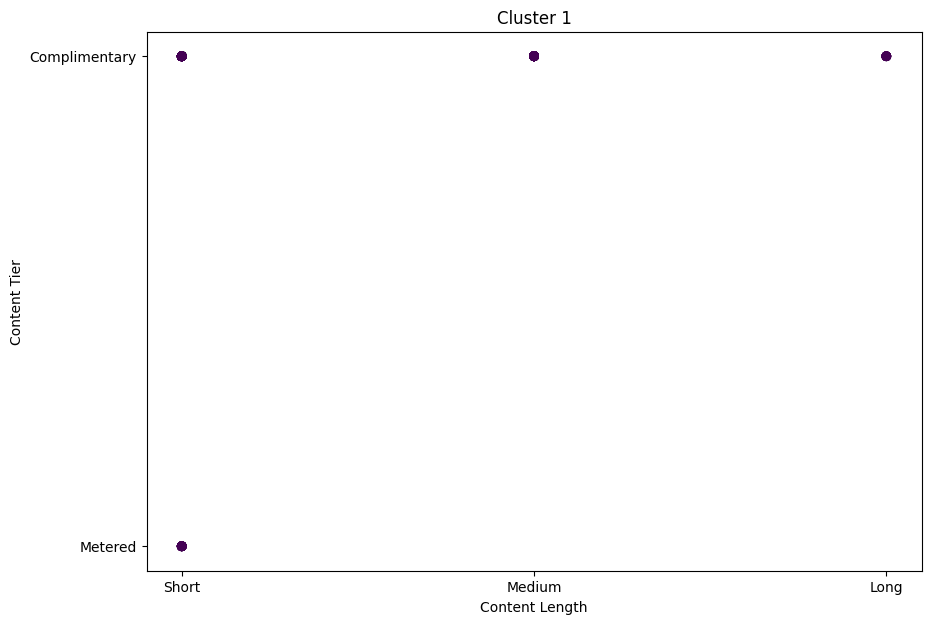

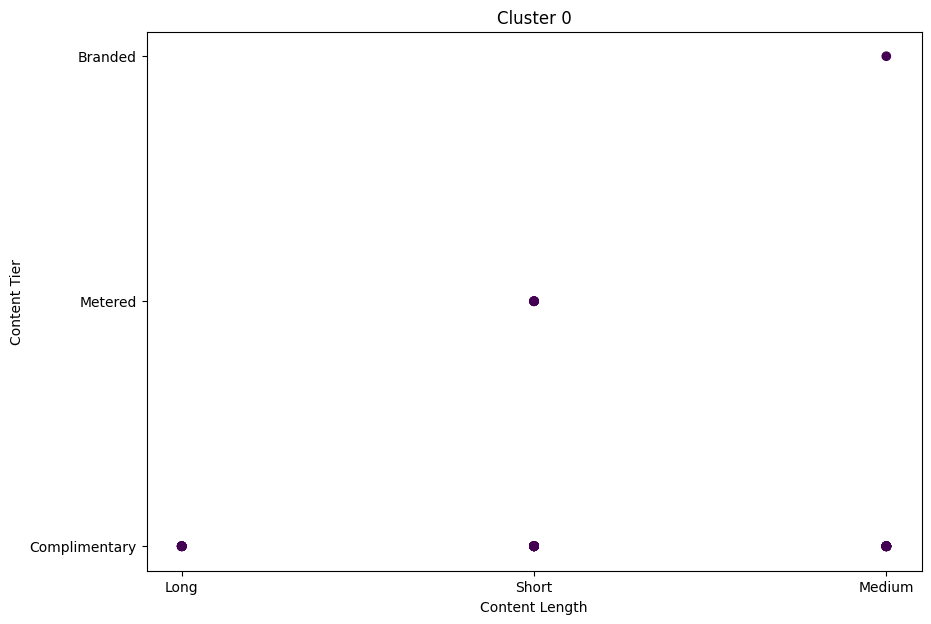

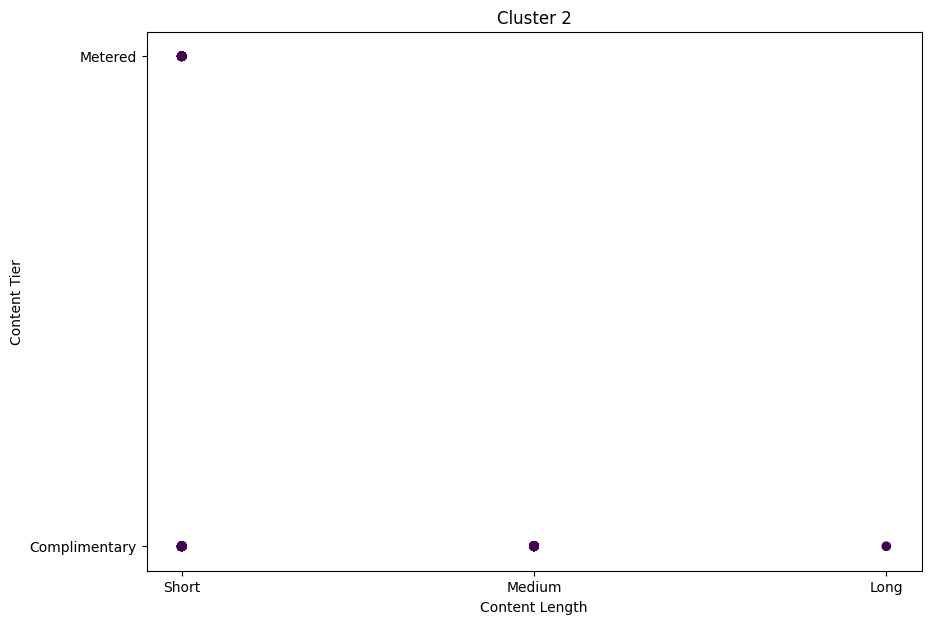

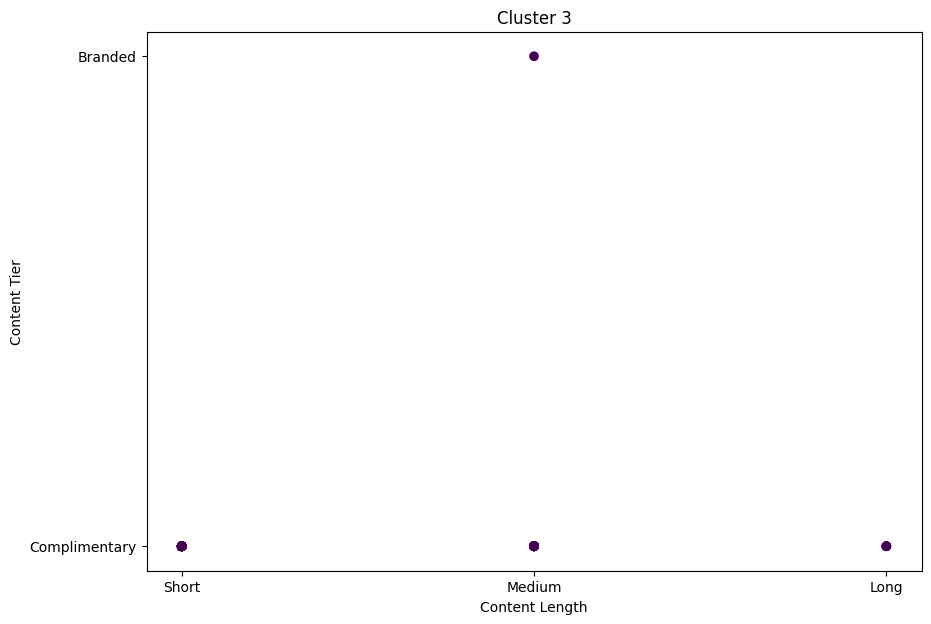

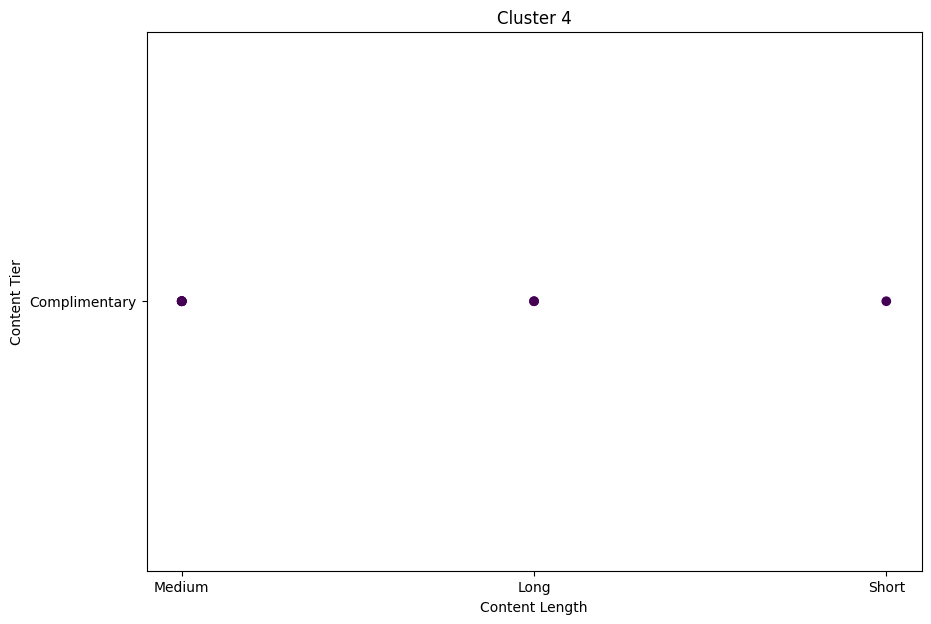

In [62]:
# prompt: visualise each cluster to see the article

import matplotlib.pyplot as plt

for cluster_label in df_updated['cluster'].unique():
    cluster_data = df_updated[df_updated['cluster'] == cluster_label]

    plt.figure(figsize=(10, 7))
    plt.scatter(cluster_data['content_length'], cluster_data['content_tier'], c=cluster_data['cluster'], cmap='viridis')
    plt.title(f"Cluster {cluster_label}")
    plt.xlabel("Content Length")
    plt.ylabel("Content Tier")
    plt.show()


In [63]:
# prompt: create a dataframe for each cluster and cluster.head()

for cluster_label in df_updated['cluster'].unique():
    cluster_data = df_updated[df_updated['cluster'] == cluster_label]
    print(f"Cluster {cluster_label}:")
    print(cluster_data.head())
    print()


Cluster 1:
     content_id                                              title  \
924     1345781                       New capacity in the pipeline   
934     1345779                           SIA reaching new heights   
935     1345780  US-South-East Asia deal flows could be the new...   
937     1345786  MI Technovation posts three-fold surge in net ...   
938     1345783  March industrial production index up 2.4%, but...   

                                                  text   section  \
924  THE data centre industry globally is seeing a ...  Business   
934  I am not a betting man, but if I were, I’d pla...  Business   
935  THE International Monetary Fund reported that ...  Business   
937  Disclaimer: by clicking the Submit button, it ...  Business   
938  Disclaimer: by clicking the Submit button, it ...  Business   

           category content_tier content_length       published_date  \
924         Economy      Metered          Short  2024-05-11 00:00:00   
934         Ins

In [54]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [57]:
%%writefile app.py
import streamlit as st
import pandas as pd


# Set the title and description of the app
st.title("Story Clustering Platform")
st.markdown("This platform displays clusters and related stories.")

# Display the unique cluster labels as options
selected_cluster = st.selectbox("Select a cluster", df_updated['cluster'].unique())

# Filter the data based on the selected cluster
cluster_data = df_updated[df_updated['cluster'] == selected_cluster]

# Display the URLs of related stories in the selected cluster
st.subheader("Related Stories:")
for url in cluster_data['url']:
    st.write(url)

Writing app.py


In [59]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 2.377s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


In [60]:
!streamlit run /content/app.py &>/content/logs.txt &

In [61]:
!npx localtunnel --port 8501

npx: installed 22 in 3.31s
your url is: https://good-files-admire.loca.lt
^C
